In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/vision3.zip -d /content/brain-tumor
!unzip /content/drive/MyDrive/vision.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/g

In [21]:
import os
import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [23]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [24]:
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [25]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [26]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,3))
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

In [27]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [28]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [29]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [30]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [31]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [32]:
batch_size = 16
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="/content/brain-tumor"

In [33]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [34]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

In [35]:
model = unet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [36]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [37]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=1,
    )

Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 0.9068 - dice_coef: 0.0932 - accuracy: 0.7653
Epoch 1: val_loss improved from inf to 0.96719, saving model to files/model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115/115 [==============================] - 159s 946ms/step - loss: 0.9068 - dice_coef: 0.0932 - accuracy: 0.7653 - val_loss: 0.9672 - val_dice_coef: 0.0327 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 2/100
115/115 [==============================] - ETA: 0s - loss: 0.8512 - dice_coef: 0.1488 - accuracy: 0.9485
Epoch 2: val_loss improved from 0.96719 to 0.96142, saving model to files/model.h5
115/115 [==============================] - 104s 903ms/step - loss: 0.8512 - dice_coef: 0.1488 - accuracy: 0.9485 - val_loss: 0.9614 - val_dice_coef: 0.0386 - val_accuracy: 0.2559 - lr: 1.0000e-04
Epoch 3/100
115/115 [==============================] - ETA: 0s - loss: 0.8095 - dice_coef: 0.1905 - accuracy: 0.9659
Epoch 3: val_loss improved from 0.96142 to 0.96119, saving model to files/model.h5
115/115 [==============================] - 105s 912ms/step - loss: 0.8095 - dice_coef: 0.1905 - accuracy: 0.9659 - val_loss: 0.9612 - val_dice_coef: 0.0389 - val_accuracy: 0.6829 - lr: 1.0000e-04
Epoch 4/100


In [38]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head(2)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.765305,0.093203,0.906797,0.0001,0.982257,0.032737,0.967192
1,1,0.948484,0.148824,0.851176,0.0001,0.255888,0.038562,0.961420


<Axes: >

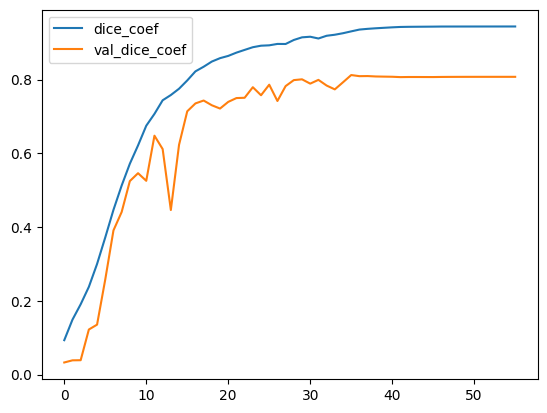

In [39]:
metrics[['dice_coef','val_dice_coef']].plot()

<Axes: >

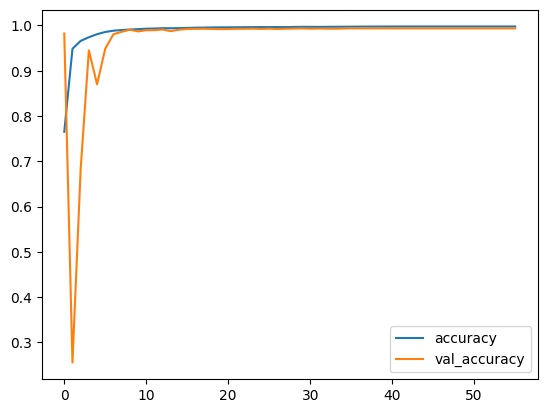

In [40]:
metrics[['accuracy','val_accuracy']].plot()

<Axes: >

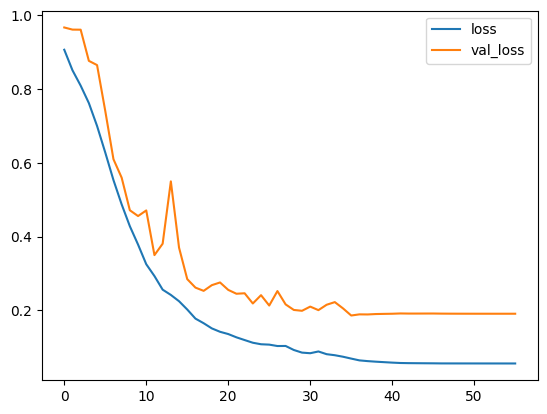

In [41]:
metrics[['loss','val_loss']].plot()

In [43]:
create_dir("results")

with CustomObjectScope({"dice_coef": dice_coef, "dice_loss": dice_loss}):
    model = tf.keras.models.load_model(os.path.join("files", "model.h5"))

In [44]:
from tqdm import tqdm
def save_results(image, mask, y_pred, save_image_path):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask, mask, mask], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)
    y_pred = y_pred * 255

    line = np.ones((H, 10, 3)) * 255

    cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [45]:
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_y)):
    name = x.split("/")[-1]

    image = cv2.imread(x, cv2.IMREAD_COLOR) ## [H, w, 3]
    image = cv2.resize(image, (W, H))       ## [H, w, 3]
    x = image/255.0                         ## [H, w, 3]
    x = np.expand_dims(x, axis=0)           ## [1, H, w, 3]

    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (W, H))

    y_pred = model.predict(x, verbose=0)[0]
    y_pred = np.squeeze(y_pred, axis=-1)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(np.int32)

    save_image_path = os.path.join("results", name)
    save_results(image, mask, y_pred, save_image_path)

    mask = mask/255.0
    mask = (mask > 0.5).astype(np.int32).flatten()
    y_pred = y_pred.flatten()

    f1_value = f1_score(mask, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask, y_pred, labels=[0, 1], average="binary", zero_division=0)
    SCORE.append([name, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"F1: {score[0]:0.5f}")
print(f"Jaccard: {score[1]:0.5f}")
print(f"Recall: {score[2]:0.5f}")
print(f"Precision: {score[3]:0.5f}")

df = pd.DataFrame(SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv", index=None)

100%|██████████| 612/612 [02:10<00:00,  4.70it/s]

F1: 0.75906
Jaccard: 0.67315
Recall: 0.75102
Precision: 0.82171


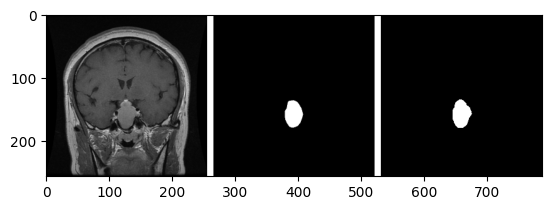

In [47]:
dir = "/content/results/"
images = os.listdir("/content/results")[:5]
img1 = plt.imread(dir+images[0])
plt.imshow(img1, cmap='gray')

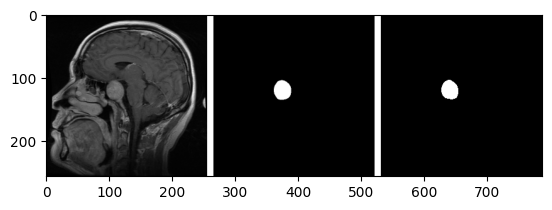

In [48]:
img1 = plt.imread(dir+images[1])
plt.imshow(img1, cmap='gray')

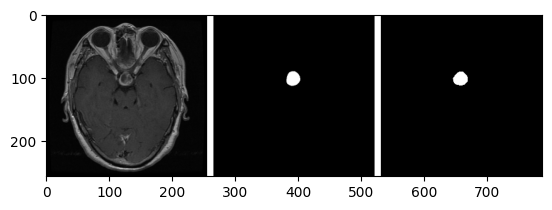

In [49]:
img1 = plt.imread(dir+images[2])
plt.imshow(img1, cmap='gray')

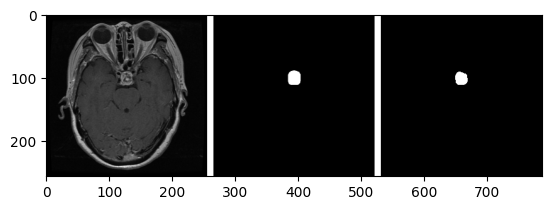

In [50]:
img1 = plt.imread(dir+images[3])
plt.imshow(img1, cmap='gray')

In [70]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define the dice_coef function
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Register the custom loss and metric functions
with tf.keras.utils.custom_object_scope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
    model1 = load_model('/content/drive/MyDrive/model_Unet.h5')

(216, 234, 3)


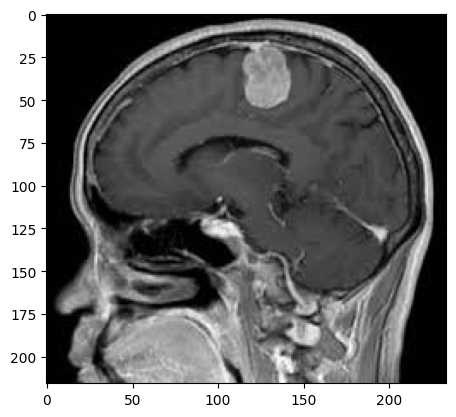

In [71]:
import cv2
img = cv2.imread('/content/Testing/meningioma/Te-me_0056.jpg')
print(img.shape)
plt.imshow(img)

(216, 234)


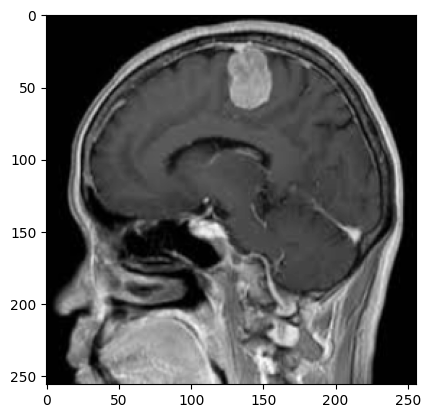

In [72]:
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_new = cv2.resize(gray_img, (256,256))
print(gray_img.shape)
plt.imshow(img_new,cmap = 'gray')

In [73]:
# import numpy as np

# Normalize your image data
img_scaled = img_new / 255

# Add batch and channel dimensions
img_scaled = np.expand_dims(img_scaled, axis=0)  # Batch dimension
img_scaled = np.expand_dims(img_scaled, axis=-1)  # Single channel dimension

# Repeat the single channel across three channels (for RGB)
img_scaled = np.repeat(img_scaled, 3, axis=-1)  # Repeat along the last axis

print(img_scaled.shape)  # Verify the shape before passing it to the model
y_pred = model1.predict(img_scaled)
y_pred = np.squeeze(y_pred, axis=-1)
y_pred = y_pred >= 0.5
y_pred = y_pred.astype(np.int32)
print(y_pred)



(1, 256, 256, 3)
1/1 [==============================] - 1s 551ms/step
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


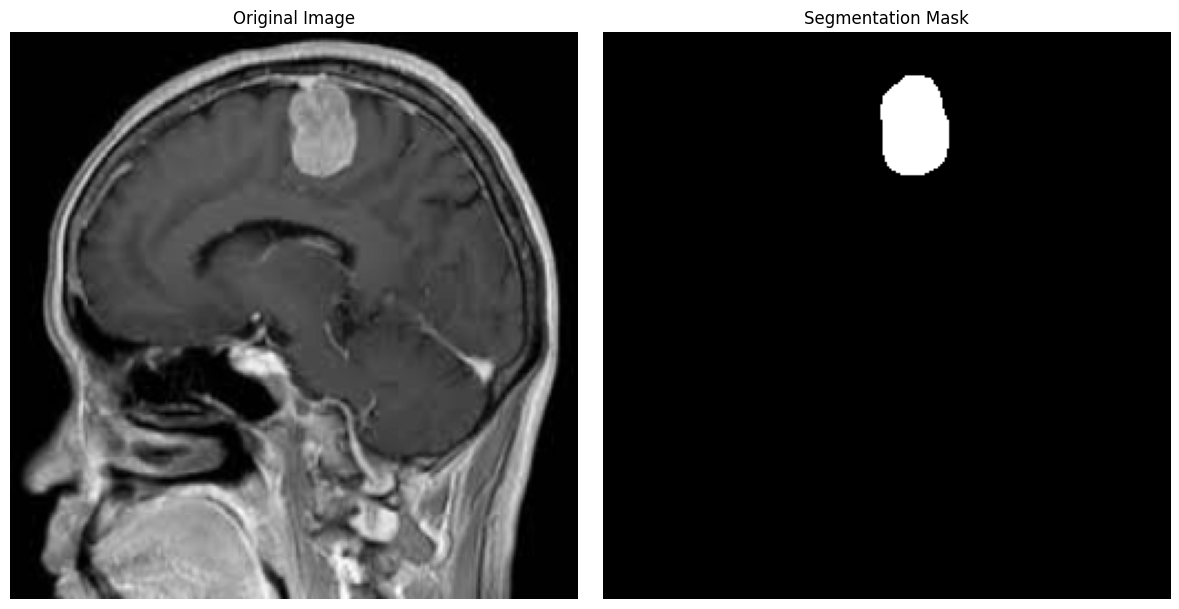

In [74]:
import matplotlib.pyplot as plt

predicted_mask = y_pred[0]
threshold = 0.5
binary_mask = (predicted_mask > threshold).astype(np.uint8)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_new,cmap = 'gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# import cv2
# contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# area = 0
# for contour in contours:
#     area += cv2.contourArea(contour)

# resolution = 100
# area_cm2 = area / (resolution ** 2)

# print(f"Diện tích của vùng được segment là: {area_cm2} cm²")
# print(f"Diện tích của vùng được segment là: {area} pixels")